This presentation has very wide content; resize your window to view it.
This line ensures content follows thenew window size.

In [111]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Extracting data from **email headers** 

### (circled in green) included in the body of an email:  
 
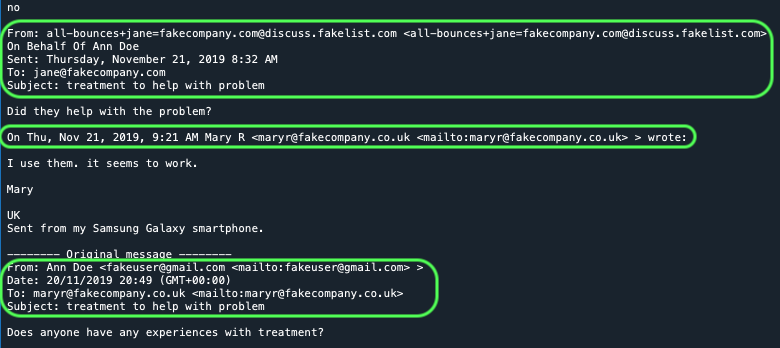

In [112]:
import qante                       # our package
from qante.tagger import Tagger,lit  # Tagger class and lit() function
from qante.query import Query        # Function to query Tagged text
from jn_regex import DATE,TIME,EMAIL # local module w/regexps for date, time, email

## Example 1: Find subheaders matching the pattern:  __On__ ... *date* ... *email* ... *email* ... __wrote__:  

In [113]:
# create tagged text object from file
f = open( 'email.txt', 'r')
txt = f.read() 
tagged_email = Tagger(txt)

# tag locations of dates, times, and emails
tagged_email.tagRE('DATE', DATE)
tagged_email.tagRE('TIME', TIME)
tagged_email.tagRE('EMAIL', EMAIL)

# tags is an ordered sequence of 5 tags:
tags = [lit('on'), 'DATE', 'TIME', 'EMAIL', lit('wrote:')]

# referenced by their positions in this predicate:
predicate = 'seq_before(0,1,2,3,4) and dist(0,4)<100'

### Query the tagged text:

The query returns a 3-tuple from *tagged_email* using *predicate* referencing *tags*.

Show Query's docstring below, which shows valid predicate syntax

In [167]:
Query?

In [165]:
qry = Query(tags, predicate, tagged_email, [1,2,3])

In [172]:
triplets = qry.execute()
tagged_email.display_tuples(triplets) # two tuples: (date, time, email)

Warning[210608]: Query was already tokenized: ['seq_before_meets', '(', '0', ',', '1', ',', '2', ',', '3', ',', '4', ',', '5', ',', '6', ',', '7', ',', '8', ')', 'and', 'dist_pred_12', '(', '0', ',', '8', ')', 'and', 'dist_pred_13', '(', '1', ',', '2', ')', 'and', 'dist_pred_14', '(', '6', ',', '7', ')', 'and', 'not_preceeded_by_mail', '(', '6', ')']
('all-bounces+jane=fakecompany.com@discuss.fakelist.com', 'thursday, november 21, 2019', '8:32 am', 'jane@fakecompany.com')
('fakeuser@gmail.com', '20/11/2019', '20:49 (gmt+00:00)', 'maryr@fakecompany.co.uk')


### We now have two 3-tuples: one for each occurrence of email maryr@fakecompany.co.uk

#### To remove the extra tuple, we simply constrain the query  to select only one of the emails, the one closer to 'wrote:'

In [118]:
pred = 'seq_before(0,1,2,3,4) and dist(3,4) < 10 and dist(0,4)<100'
qry = Query(tags, pred, tagged_email, [1,2,3])
triplets = qry.execute()
tagged_email.display_tuples(triplets)

('thu, nov 21, 2019', '9:21 am ', 'maryr@fakecompany.co.uk')


## Example 2: Extract emails, dates, and times, from email headers

from same email as above
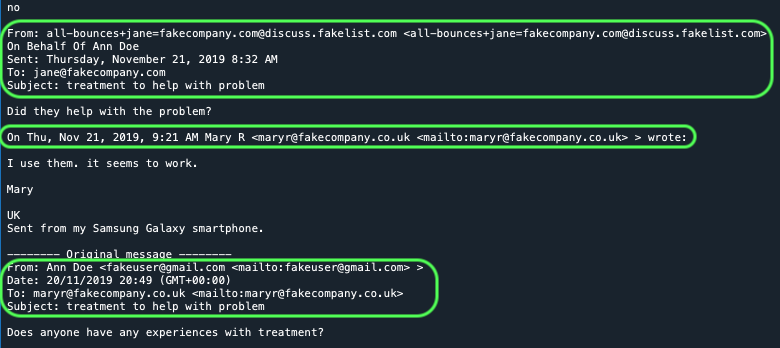

In [169]:
if len(tagged_email.get_locs('SENTDATETIME')) == 0:       # to allow re-exection of this cell w/o error
  tagged_email.tagRE('SENTDATETIME', '(sent:)|(date:)')
    
tags = [lit('from:'),  'EMAIL',  lit('>'), 
    'SENTDATETIME', 'DATE', 'TIME', 
    lit('to:'),  'EMAIL',  
    lit('subject:')
]
pred = ('seq_before_meets(0,1,2,3,4,5,6,7,8)'
    ' and dist(0,8) < 350 and dist(1,2) < 5 and dist(6,7) < 5')
qry = Query(tags, pred, tagged_email, [1,4,5,7])  # (email, date, time, email)
quadruplets = qry.execute()
tagged_email.display_tuples(quadruplets)

('all-bounces+jane=fakecompany.com@discuss.fakelist.com', 'thursday, november 21, 2019', '8:32 am', 'jane@fakecompany.com')
('fakeuser@gmail.com', '20/11/2019', '20:49 (gmt+00:00)', 'maryr@fakecompany.co.uk')
('fakeuser@gmail.com', '20/11/2019', '20:49 (gmt+00:00)', 'maryr@fakecompany.co.uk')


### The reason of the duplicate rows above is because "to:" appears twice (to:, mailto:)
#### To skip the 'to:' in 'mailto:', define a new predicate that returns False if text preceeding location is 'mail'

In [174]:
pred = ('seq_before_meets(0,1,2,3,4,5,6,7,8)'
    ' and dist(0,8) < 350 and dist(1,2) < 5 and dist(6,7) < 5'
    ' and not_preceeded_by_mail(6)')
qry = Query(tags, pred, tagged_email, [1,4,5,7])
qry.UDP('not_preceeded_by_mail',
    lambda l: tagged_email.text[l[0].start()-4:l[0].start()] != 'mail'
)
triplets = qry.execute()
tagged_email.display_tuples(triplets)

('all-bounces+jane=fakecompany.com@discuss.fakelist.com', 'thursday, november 21, 2019', '8:32 am', 'jane@fakecompany.com')
('fakeuser@gmail.com', '20/11/2019', '20:49 (gmt+00:00)', 'maryr@fakecompany.co.uk')


To illustrate additional functionality, we consider an electricity bill.
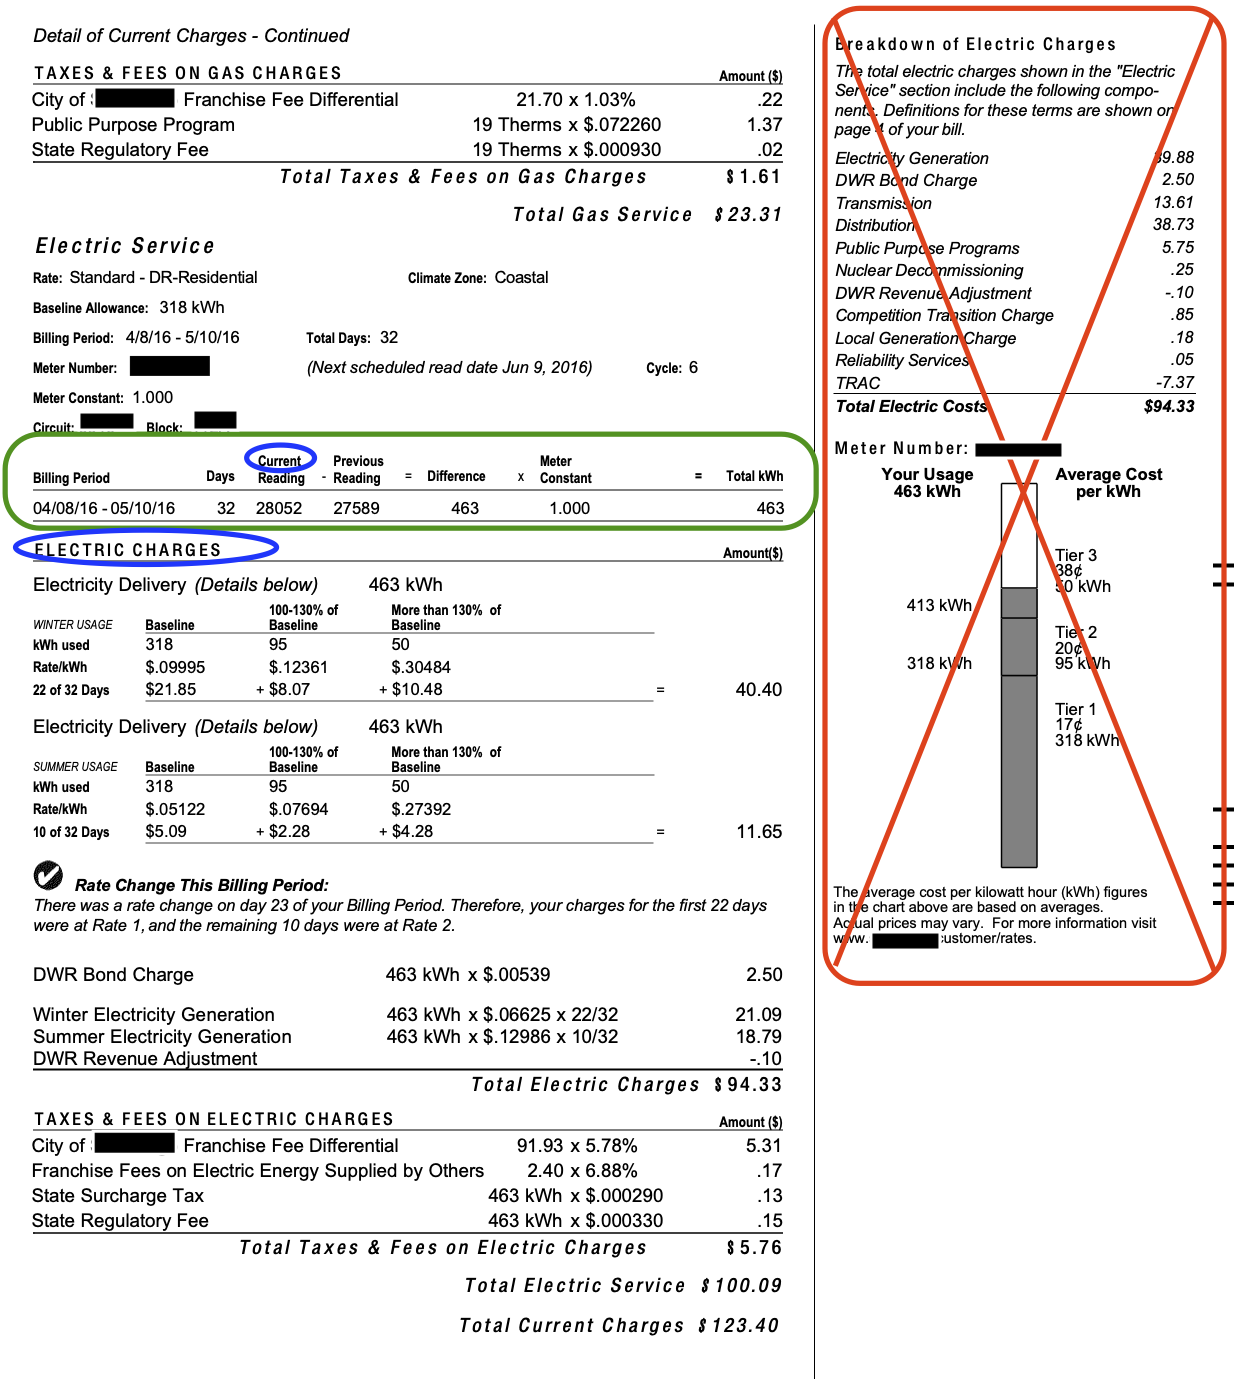
We first get the text with one page of the bill

In [9]:
import qante.utilities as ut
TXT_FILE = 'bill.txt'
f = open(  TXT_PATH+TXT_FILE, 'r')
txt = f.read() 
stat = Tagger(txt) # statement to tag
print(txt)

Detail of Current Charges - Continued                                                                                  Breakdown of Electric Charges
TAXES & FEES ON GAS CHARGES                                                                               Amount ($)   The total electric charges shown in the "Electric
                                                                                                                       Service" section include the following compo-
City of xxxxxxxxx Franchise Fee Differential      21.70 x 1.03%                                               .22
                                                                                                                       nents. Definitions for these terms are shown on
Public Purpose Program                       19 Therms x $.072260                                            1.37      page 4 of your bill.
State Regulatory Fee                         19 Therms x $.000930                               

Then, we get rid of column on the right

In [10]:
# get right column of text and mark it as noise
str_in_column = 'the total electric charges shown in the "electric'
stat.tag_list('NOISE', ut.get_column(stat.text, str_in_column))
clean_elec_txt = stat.replace_tag('NOISE', '')
print(clean_elec_txt)

detail of current charges - continued                                                                                  
taxes & fees on gas charges                                                                               amount ($)   
                                                                                                                       
city of xxxxxxxxx franchise fee differential      21.70 x 1.03%                                               .22
                                                                                                                       
public purpose program                       19 therms x $.072260                                            1.37      
state regulatory fee                         19 therms x $.000930                                             .02                                
                            total taxes & fees on gas charges                                              $1.61                            

Now, we get the text of the table

In [11]:
from qante.loctuple import open_right_span
from qante.loclist import shortest
elec = Tagger(clean_elec_txt)
elec.tagRE('LINE', ut.LINE)
tags = ['LINE', lit('current'), lit('electric charges')]
qry = Query(tags, 'subinterval(1, 0) and before(0, 2)', elec, [0,2])
pairs = qry.execute()
locs = shortest(list(map(open_right_span, pairs)))
table_txt = elec.get_text_loc(locs[0])
print(table_txt)

                                   current       previous                           meter
billing period              days   reading     - reading      =   difference    x   constant          =    total kwh                           
                                                                                                                                                    
04/08/16 - 05/10/16          32    28052         27589                463             1.000                    463




We extract fields from table

In [12]:
from qante.table import get_table 
mytable = get_table(table_txt,2)
print(mytable)

[{'billing period': '04/08/16 - 05/10/16', 'days': '32', 'current reading': '28052', 'previous - reading': '27589', 'difference': '463', 'meter constant': '1.000', 'total kwh': '463'}]
